# 15. 도로 영역을 찾자! - 세그멘테이션 모델 만들기 [프로젝트]

|평가문항|상세기준|
|:---|:---|
|1. U-Net을 통한 세그멘테이션 작업이 정상적으로 진행되었는가?|KITTI 데이터셋 구성, U-Net 모델 훈련, 결과물 시각화의 한 사이클이 정상 수행되어 세그멘테이션 결과 이미지를 제출하였다.|
|2. U-Net++ 모델이 성공적으로 구현되었는가?|U-Net++ 모델을 스스로 구현하여 학습 진행 후 세그멘테이션 결과까지 정상 진행되었다.|
|3. U-Net과 U-Net++ 두 모델의 성능이 정량적/정성적으로 잘 비교되었는가?|U-Net++ 의 세그멘테이션 결과 사진과 IoU 계산치를 U-Net과 비교하여 우월함을 확인하였다.|

## Step 1. KITTI 데이터셋 수집과 구축

다운로드한 KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋을 구축합니다. 이때 주의할 점이 있습니다. U-Net++는 메모리 사용량이 U-Net보다 꽤 많아집니다. 그러니 배치 사이즈를 적절히 줄여서 설정하시기를 권합니다.

In [1]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [56]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

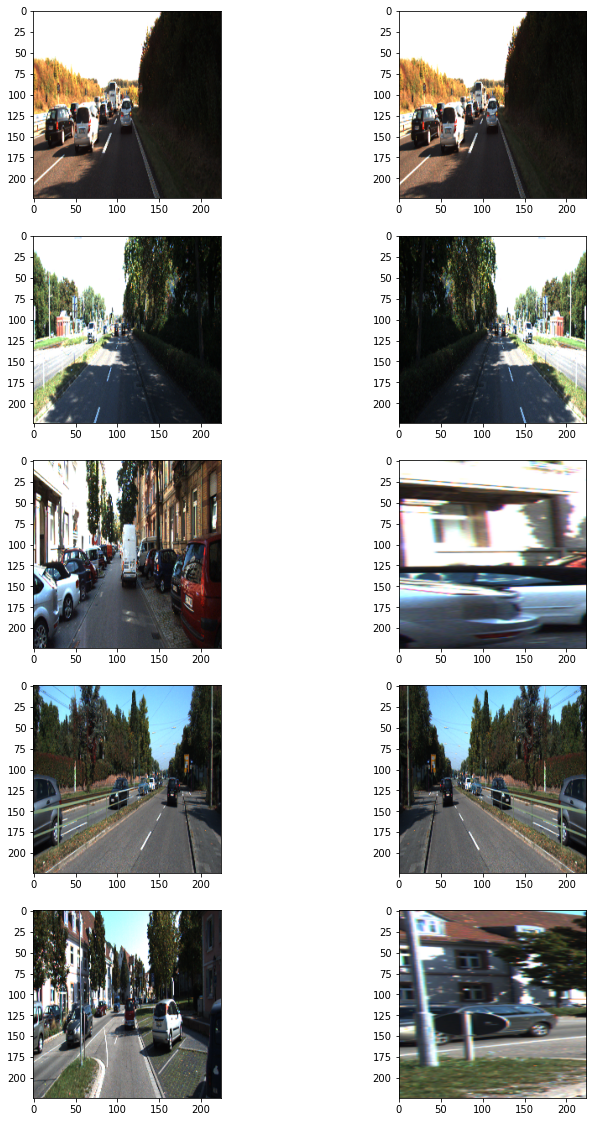

In [57]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [58]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [59]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## Step 2. U-Net, U-Net++ 모델의 구현

U-Net의 모델 구조와 소스코드를 면밀히 비교해 보다 보면, U-Net++를 어떻게 구현할 수 있을지에 대한 방안을 떠올릴 수 있을 것입니다. 이 과정을 통해 U-Net 자체에 대한 이해도도 증진될 것입니다. 그 외 적절히 U-Net의 백본 구조, 기타 파라미터 변경 등을 통해 추가적인 성능 향상이 가능할 수도 있습니다.

In [48]:
from keras import layers

def UNet(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    c1 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(inputs)
    c1 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(c1)  
    p1 =layers.MaxPooling2D(pool_size=(2, 2))(c1) 
    
    c2 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(p1)
    c2 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(c2)
    p2 = layers.MaxPooling2D(pool_size=(2, 2))(c2)
    
    c3 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(p2)
    c3 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(c3)
    dr1 = layers.Dropout(0.4)(c3)    
    p3 = layers.MaxPooling2D(pool_size=(2, 2))(dr1)
    
    c4 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same')(p3)
    c4 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same')(c4)
    dr2 = layers.Dropout(0.4)(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(dr2)
    
    c5 = layers.Conv2D(1024, 3, activation = 'relu', padding = 'same')(p4)
    c5 = layers.Conv2D(1024, 3, activation = 'relu', padding = 'same')(c5)
    
    up1 = Conv2D(512, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(c5))
    merge1 = concatenate([dr2,up1], axis = 3)
    c6 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same')(merge1)
    c6 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same')(c6)
    dr3 = layers.Dropout(0.4)(c6)
    
    up2 = Conv2D(256, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(dr3))
    merge2 = concatenate([dr1,up2], axis = 3)
    c7 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(merge2)
    c7 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(c7)
    dr4 = layers.Dropout(0.4)(c7)
    
    up3 = Conv2D(128, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(dr4))
    merge3 = concatenate([c2,up3], axis = 3)
    c8 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(merge3)
    c8 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(c8)
    dr5 = layers.Dropout(0.4)(c8)
    
    up4 = Conv2D(64, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(dr5))
    merge4 = concatenate([c1,up4], axis = 3)
    c9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(merge4)
    c9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(c9)

    c10 = layers.Conv2D(1, 1, activation = 'sigmoid')(c9)
    model = Model(inputs = inputs, outputs=[c10])
    return model

In [49]:
model = UNet()
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_197 (Conv2D)             (None, 224, 224, 64) 1792        input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_198 (Conv2D)             (None, 224, 224, 64) 36928       conv2d_197[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_24 (MaxPooling2D) (None, 112, 112, 64) 0           conv2d_198[0][0]                 
____________________________________________________________________________________________

In [50]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
history1 = model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 24s 884ms/step - loss: 0.6707 - val_loss: 0.5241
Epoch 2/100
11/11 [==============================] - 9s 803ms/step - loss: 0.3062 - val_loss: 0.2675
Epoch 3/100
11/11 [==============================] - 9s 800ms/step - loss: 0.0666 - val_loss: 0.0361
Epoch 4/100
11/11 [==============================] - 9s 790ms/step - loss: 0.0343 - val_loss: 0.0322
Epoch 5/100
11/11 [==============================] - 9s 780ms/step - loss: 0.0261 - val_loss: 0.0279
Epoch 6/100
11/11 [==============================] - 9s 789ms/step - loss: 0.0328 - val_loss: 0.0353
Epoch 7/100
11/11 [==============================] - 8s 773ms/step - loss: 0.0324 - val_loss: 0.0308
Epoch 8/100
11/11 [==============================] - 9s 775ms/step - loss: 0.0325 - val_loss: 0.0372
Epoch 9/100
11/11 [==============================] - 9s 785ms/step - loss: 0.0319 - val_loss: 0.0285
Epoch 10/100
11/11 [==============================] - 9s 778ms/step - loss: 0.0291 - val_l

In [51]:
#가중치 초기화를 적용한 UNET

def UNet_kernel_init(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    c1 = layers.Conv2D(64, 3, padding = 'same',kernel_initializer = 'he_normal')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    c1 = layers.Conv2D(64, 3, padding = 'same',kernel_initializer = 'he_normal')(c1) 
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 =layers.MaxPooling2D(pool_size=(2, 2))(c1) 
    
    c2 = layers.Conv2D(128, 3, padding = 'same',kernel_initializer = 'he_normal')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    c2 = layers.Conv2D(128, 3, padding = 'same',kernel_initializer = 'he_normal')(c2)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = layers.MaxPooling2D(pool_size=(2, 2))(c2)
    
    c3 = layers.Conv2D(256, 3, padding = 'same',kernel_initializer = 'he_normal')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    c3 = layers.Conv2D(256, 3, padding = 'same',kernel_initializer = 'he_normal')(c3)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    dr1 = layers.Dropout(0.4)(c3)    
    p3 = layers.MaxPooling2D(pool_size=(2, 2))(dr1)
    
    c4 = layers.Conv2D(512, 3, padding = 'same',kernel_initializer = 'he_normal')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    c4 = layers.Conv2D(512, 3, padding = 'same',kernel_initializer = 'he_normal')(c4)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    dr2 = layers.Dropout(0.4)(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(dr2)
    
    c5 = layers.Conv2D(1024, 3, padding = 'same',kernel_initializer = 'he_normal')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)
    c5 = layers.Conv2D(1024, 3, padding = 'same',kernel_initializer = 'he_normal')(c5)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)
    
    up1 = Conv2DTranspose(512, kernel_size=2, strides=2, padding ='same',kernel_initializer = 'he_normal')(c5)
    merge1 = concatenate([dr2,up1], axis = 3)
    c6 = layers.Conv2D(512, 3, padding = 'same',kernel_initializer = 'he_normal')(merge1)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)
    c6 = layers.Conv2D(512, 3, padding = 'same',kernel_initializer = 'he_normal')(c6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)
    dr3 = layers.Dropout(0.4)(c6)
    
    up2 = Conv2DTranspose(256, kernel_size=2, strides=2, padding ='same',kernel_initializer = 'he_normal')(dr3)
    merge2 = concatenate([dr1,up2], axis = 3)
    c7 = layers.Conv2D(256, 3, padding = 'same',kernel_initializer = 'he_normal')(merge2)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    c7 = layers.Conv2D(256, 3, padding = 'same',kernel_initializer = 'he_normal')(c7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    dr4 = layers.Dropout(0.4)(c7)
    
    up3 = Conv2DTranspose(128, kernel_size=2, strides=2, padding ='same',kernel_initializer = 'he_normal')(dr4)
    merge3 = concatenate([c2,up3], axis = 3)
    c8 = layers.Conv2D(128, 3, padding = 'same',kernel_initializer = 'he_normal')(merge3)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)
    c8 = layers.Conv2D(128, 3, padding = 'same',kernel_initializer = 'he_normal')(c8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)
    dr5 = layers.Dropout(0.4)(c8)
    
    up4 = Conv2DTranspose(64, kernel_size=2, strides=2, padding ='same',kernel_initializer = 'he_normal')(dr5)
    merge4 = concatenate([c1,up4], axis = 3)
    c9 = layers.Conv2D(64, 3, padding = 'same',kernel_initializer = 'he_normal')(merge4)
    c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)
    c9 = layers.Conv2D(64, 3, padding = 'same',kernel_initializer = 'he_normal')(c9)
    c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)

    c10 = layers.Conv2D(1, 1, activation = 'sigmoid')(c9)
    model = Model(inputs = inputs, outputs=[c10])
    return model

In [52]:
model2 = UNet_kernel_init()
model2.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_220 (Conv2D)             (None, 224, 224, 64) 1792        input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_106 (BatchN (None, 224, 224, 64) 256         conv2d_220[0][0]                 
__________________________________________________________________________________________________
activation_106 (Activation)     (None, 224, 224, 64) 0           batch_normalization_106[0][0]    
____________________________________________________________________________________________

In [53]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_kernel_init.h5'

model2.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
history2 = model2.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model2.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 11s 708ms/step - loss: 0.8639 - val_loss: 0.8030
Epoch 2/100
11/11 [==============================] - 7s 670ms/step - loss: 0.7354 - val_loss: 0.7465
Epoch 3/100
11/11 [==============================] - 7s 674ms/step - loss: 0.6408 - val_loss: 0.6454
Epoch 4/100
11/11 [==============================] - 7s 675ms/step - loss: 0.5763 - val_loss: 0.6230
Epoch 5/100
11/11 [==============================] - 7s 680ms/step - loss: 0.5430 - val_loss: 0.6025
Epoch 6/100
11/11 [==============================] - 7s 682ms/step - loss: 0.4988 - val_loss: 0.6210
Epoch 7/100
11/11 [==============================] - 8s 686ms/step - loss: 0.4768 - val_loss: 0.5442
Epoch 8/100
11/11 [==============================] - 8s 691ms/step - loss: 0.4529 - val_loss: 0.5182
Epoch 9/100
11/11 [==============================] - 8s 694ms/step - loss: 0.4680 - val_loss: 0.4942
Epoch 10/100
11/11 [==============================] - 8s 692ms/step - loss: 0.4112 - val_l

U-Net++과 U-Net 차이점
1. Re-designed skip pathways : U-Net에서도 Skip-Connection을 해주는 부분이 있었지만, U-Net++에서는 DenseNet의 아이디어를 차용하여 Encoder(수축 경로)와 Decoder(확장 경로)사이의 Semantic(의미적) Gap을 연결시켜 줍니다.
2. Deep Supervision : 각 브랜치의 출력(빨간색 선으로 표시된 부분)을 평균해서 최종 결과로서 사용하는 방법입니다.

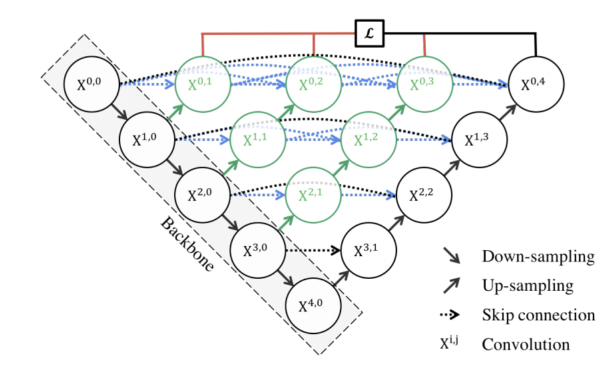

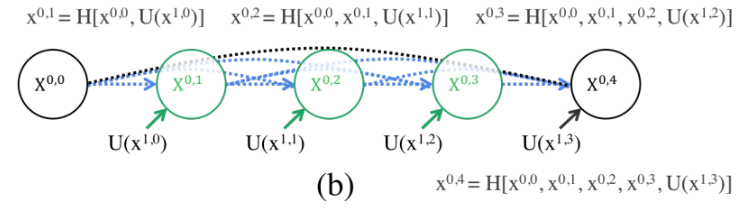

위 그림은 Feature map(이미지)이 첫 번째 Skip Pathway를 통과하는 것을 보여줍니다.  
기존 U-Net에서는 X0_0에서 X0_4로 가는 하나의 Skip만이 존재하였습니다. 그러나, U-Net++에서는 X0_0이 크기가 키워진(Upsampling) X1_0과 Concatenate되어 X0_1로 가는 것을 볼 수 있습니다. 그리고 이렇게 만들어진 X0_1은 또 다시 Upsampling된 X1_1과 Concatenate되어 X1_2로 흘려줍니다. 이런식으로 하면 저자들은 Encoder와 Decoder의 Feature map간의 Semantic Gap을 더 줄일 수 있게 된다고 언급합니다.  
그리고, Deep Supervision은 여러 Semantic Level(위 구조에서는 4개)은 각각 Feature map을 생성하여 정보를 가지고 있습니다. 따라서, 4개의 시맨틱 정보를 모두 이용하여 평균내어 결과를 예측하였습니다. Deep Supervision 방법은 선택적으로 적용할 수 있습니다.

In [18]:
# UNET++

def UNet_plus_plus_kernel_init(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    #backbone , Encoder(수축 경로)
    #conv0_0
    c0_0 = layers.Conv2D(64, 3, padding = 'same',kernel_initializer = 'he_normal')(inputs)
    c0_0 = BatchNormalization()(c0_0)
    c0_0 = Activation('relu')(c0_0)
    c0_0 = layers.Conv2D(64, 3, padding = 'same',kernel_initializer = 'he_normal')(c0_0)
    c0_0 = BatchNormalization()(c0_0)
    c0_0 = Activation('relu')(c0_0)
    p0_0 =layers.MaxPooling2D(pool_size=(2, 2))(c0_0) 
    
    #conv1_0
    c1_0 = layers.Conv2D(128, 3, padding = 'same',kernel_initializer = 'he_normal')(p0_0)
    c1_0 = BatchNormalization()(c1_0)
    c1_0 = Activation('relu')(c1_0)
    c1_0 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(c1_0)
    c1_0 = BatchNormalization()(c1_0)
    c1_0 = Activation('relu')(c1_0)
    p1_0 = layers.MaxPooling2D(pool_size=(2, 2))(c1_0)
    
    #conv2_0
    c2_0 = layers.Conv2D(256, 3, padding = 'same',kernel_initializer = 'he_normal')(p1_0)
    c2_0 = BatchNormalization()(c2_0)
    c2_0 = Activation('relu')(c2_0)
    c2_0 = layers.Conv2D(256, 3, padding = 'same',kernel_initializer = 'he_normal')(c2_0)
    c2_0 = BatchNormalization()(c2_0)
    c2_0 = Activation('relu')(c2_0)
    dr1 = layers.Dropout(0.4)(c2_0)    
    p2_0 = layers.MaxPooling2D(pool_size=(2, 2))(dr1)
    
    #conv3_0
    c3_0 = layers.Conv2D(512, 3, padding = 'same',kernel_initializer = 'he_normal')(p2_0)
    c3_0 = BatchNormalization()(c3_0)
    c3_0 = Activation('relu')(c3_0)
    c3_0 = layers.Conv2D(512, 3, padding = 'same',kernel_initializer = 'he_normal')(c3_0)
    c3_0 = BatchNormalization()(c3_0)
    c3_0 = Activation('relu')(c3_0)
    dr2 = layers.Dropout(0.4)(c3_0)
    p3_0 = layers.MaxPooling2D(pool_size=(2, 2))(dr2)
    
    #conv4_0
    c4_0 = layers.Conv2D(1024, 3, padding = 'same',kernel_initializer = 'he_normal')(p3_0)
    c4_0 = BatchNormalization()(c4_0)
    c4_0 = Activation('relu')(c4_0)
    c4_0 = layers.Conv2D(1024, 3, padding = 'same',kernel_initializer = 'he_normal')(c4_0)
    c4_0 = BatchNormalization()(c4_0)
    c4_0 = Activation('relu')(c4_0)
    
    
    #skip connection, Semantic(의미적) Gap
    #conv0_1
    c1_0up = Conv2D(64, 2, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(c1_0))
    c0_1in = Concatenate()([c0_0, c1_0up])
    c0_1 = layers.Conv2D(64, 3, padding = 'same',kernel_initializer = 'he_normal')(c0_1in)
    c0_1 = BatchNormalization()(c0_1)
    c0_1 = Activation('relu')(c0_1)
    c0_1 = layers.Conv2D(64, 3, padding = 'same',kernel_initializer = 'he_normal')(c0_1)
    c0_1 = BatchNormalization()(c0_1)
    c0_1 = Activation('relu')(c0_1)
    
    #conv1_1
    c2_0up = Conv2D(128, 2, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(c2_0))
    c1_1in = Concatenate()([c1_0, c2_0up])
    c1_1 = layers.Conv2D(128, 3, padding = 'same',kernel_initializer = 'he_normal')(c1_1in)
    c1_1 = BatchNormalization()(c1_1)
    c1_1 = Activation('relu')(c1_1)
    c1_1 = layers.Conv2D(128, 3, padding = 'same',kernel_initializer = 'he_normal')(c1_1)
    c1_1 = BatchNormalization()(c1_1)
    c1_1 = Activation('relu')(c1_1)
    
    #conv2_1
    c3_0up = Conv2D(256, 2, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(c3_0))
    c2_1in = Concatenate()([c2_0, c3_0up])
    c2_1 = layers.Conv2D(256, 3, padding = 'same',kernel_initializer = 'he_normal')(c2_1in)
    c2_1 = BatchNormalization()(c2_1)
    c2_1 = Activation('relu')(c2_1)
    c2_1 = layers.Conv2D(256, 3, padding = 'same',kernel_initializer = 'he_normal')(c2_1)
    c2_1 = BatchNormalization()(c2_1)
    c2_1 = Activation('relu')(c2_1)
    
    #conv0_2
    c1_1up = Conv2D(64, 2, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(c1_1))
    c0_2in = Concatenate()([c0_0, c0_1,c1_1up])
    c0_2 = layers.Conv2D(64, 3, padding = 'same',kernel_initializer = 'he_normal')(c0_2in)
    c0_2 = BatchNormalization()(c0_2)
    c0_2 = Activation('relu')(c0_2)
    c0_2 = layers.Conv2D(64, 3, padding = 'same',kernel_initializer = 'he_normal')(c0_2)
    c0_2 = BatchNormalization()(c0_2)
    c0_2 = Activation('relu')(c0_2)
    
    #conv1_2
    c2_1up = Conv2D(128, 2, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(c2_1))
    c1_2in = Concatenate()([c1_0, c1_1,c2_1up])
    c1_2 = layers.Conv2D(128, 3, padding = 'same',kernel_initializer = 'he_normal')(c1_2in)
    c1_2 = BatchNormalization()(c1_2)
    c1_2 = Activation('relu')(c1_2)
    c1_2 = layers.Conv2D(128, 3, padding = 'same',kernel_initializer = 'he_normal')(c1_2)
    c1_2 = BatchNormalization()(c1_2)
    c1_2 = Activation('relu')(c1_2)
    
    #conv0_3
    c1_3up = Conv2D(64, 2, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(c1_2))
    c0_3in = Concatenate()([c0_0, c0_1,c0_2,c1_1up])
    c0_3 = layers.Conv2D(64, 3, padding = 'same',kernel_initializer = 'he_normal')(c0_3in)
    c0_3 = BatchNormalization()(c0_3)
    c0_3 = Activation('relu')(c0_3)
    c0_3 = layers.Conv2D(64, 3, padding = 'same',kernel_initializer = 'he_normal')(c0_3)
    c0_3 = BatchNormalization()(c0_3)
    c0_3 = Activation('relu')(c0_3)
    
    
    
    # Decoder(확장 경로)
    #conv3_1
    up3_1 = Conv2D(512, 2, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(c4_0))
    merge1 = concatenate([up3_1,c3_0])
    c3_1 = layers.Conv2D(512, 3, padding = 'same',kernel_initializer = 'he_normal')(merge1)
    c3_1 = BatchNormalization()(c3_1)
    c3_1 = Activation('relu')(c3_1)
    c3_1 = layers.Conv2D(512, 3, padding = 'same',kernel_initializer = 'he_normal')(c3_1)
    c3_1 = BatchNormalization()(c3_1)
    c3_1 = Activation('relu')(c3_1)
    dr3 = layers.Dropout(0.4)(c3_1)
    
    #conv2_2
    up2_2 = Conv2D(256, 2, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(dr3))
    merge2 = concatenate([up2_2,c2_0,c2_1])
    c2_2 = layers.Conv2D(256, 3, padding = 'same',kernel_initializer = 'he_normal')(merge2)
    c2_2 = BatchNormalization()(c2_2)
    c2_2 = Activation('relu')(c2_2)
    c2_2 = layers.Conv2D(256, 3, padding = 'same',kernel_initializer = 'he_normal')(c2_2)
    c2_2 = BatchNormalization()(c2_2)
    c2_2 = Activation('relu')(c2_2)
    dr4 = layers.Dropout(0.4)(c2_2)
    
    #conv1_3
    up1_3 = Conv2D(128, 2, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(dr4))
    merge3 = concatenate([up1_3,c1_0,c1_1,c1_2])
    c1_3 = layers.Conv2D(128, 3, padding = 'same',kernel_initializer = 'he_normal')(merge3)
    c1_3 = BatchNormalization()(c1_3)
    c1_3 = Activation('relu')(c1_3)
    c1_3 = layers.Conv2D(128, 3, padding = 'same',kernel_initializer = 'he_normal')(c1_3)
    c1_3 = BatchNormalization()(c1_3)
    c1_3 = Activation('relu')(c1_3)
    dr5 = layers.Dropout(0.4)(c1_3)
    
    #conv0_4
    up0_4 = Conv2D(64, 2, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(dr5))
    merge4 = concatenate([up0_4,c0_0,c0_1,c0_2,c0_3])
    c0_4 = layers.Conv2D(64, 3, padding = 'same',kernel_initializer = 'he_normal')(merge4)
    c0_4 = BatchNormalization()(c0_4)
    c0_4 = Activation('relu')(c0_4)
    c0_4 = layers.Conv2D(64, 3, padding = 'same',kernel_initializer = 'he_normal')(c0_4)
    c0_4 = BatchNormalization()(c0_4)
    c0_4 = Activation('relu')(c0_4)

    #output
    output = layers.Conv2D(1, 1, activation = 'sigmoid')(c0_4)
    model = Model(inputs = inputs, outputs=[output])
    return model

In [19]:
model3 = UNet_plus_plus_kernel_init()
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_61 (Conv2D)              (None, 224, 224, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_46 (BatchNo (None, 224, 224, 64) 256         conv2d_61[0][0]                  
__________________________________________________________________________________________________
activation_46 (Activation)      (None, 224, 224, 64) 0           batch_normalization_46[0][0]     
____________________________________________________________________________________________

In [20]:
from keras import backend as K

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [37]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_plus_plus.h5'

model3.compile(optimizer = Adam(1e-4), loss = dice_coef_loss)
history3 = model3.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model3.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
22/22 [==============================] - 31s 1s/step - loss: 0.7552 - val_loss: 0.7046
Epoch 2/100
22/22 [==============================] - 27s 1s/step - loss: 0.7812 - val_loss: 0.7274
Epoch 3/100
22/22 [==============================] - 27s 1s/step - loss: 0.7711 - val_loss: 0.7367
Epoch 4/100
22/22 [==============================] - 27s 1s/step - loss: 0.7399 - val_loss: 0.7250
Epoch 5/100
22/22 [==============================] - 27s 1s/step - loss: 0.7711 - val_loss: 0.7331
Epoch 6/100
22/22 [==============================] - 27s 1s/step - loss: 0.7821 - val_loss: 0.7335
Epoch 7/100
22/22 [==============================] - 27s 1s/step - loss: 0.7358 - val_loss: 0.7431
Epoch 8/100
22/22 [==============================] - 27s 1s/step - loss: 0.7826 - val_loss: 0.7414
Epoch 9/100
22/22 [==============================] - 27s 1s/step - loss: 0.7506 - val_loss: 0.7303
Epoch 10/100
22/22 [==============================] - 27s 1s/step - loss: 0.7289 - val_loss: 0.7195
Epoch 11/

In [60]:
# UNET++

def UNet_plus_plus(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    #backbone , Encoder(수축 경로)
    #conv0_0
    c0_0 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(inputs)
    c0_0 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(c0_0)  
    p0_0 =layers.MaxPooling2D(pool_size=(2, 2))(c0_0) 
    
    #conv1_0
    c1_0 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(p0_0)
    c1_0 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(c1_0)
    p1_0 = layers.MaxPooling2D(pool_size=(2, 2))(c1_0)
    
    #conv2_0
    c2_0 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(p1_0)
    c2_0 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(c2_0)
    dr1 = layers.Dropout(0.4)(c2_0)    
    p2_0 = layers.MaxPooling2D(pool_size=(2, 2))(dr1)
    
    #conv3_0
    c3_0 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same')(p2_0)
    c3_0 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same')(c3_0)
    dr2 = layers.Dropout(0.4)(c3_0)
    p3_0 = layers.MaxPooling2D(pool_size=(2, 2))(dr2)
    
    #conv4_0
    c4_0 = layers.Conv2D(1024, 3, activation = 'relu', padding = 'same')(p3_0)
    c4_0 = layers.Conv2D(1024, 3, activation = 'relu', padding = 'same')(c4_0)
    
    
    
    #skip connection, Semantic(의미적) Gap
    #conv0_1
    c1_0up = Conv2DTranspose(64, kernel_size=2, strides=2, padding ='same')(c1_0)
    c0_1in = Concatenate()([c0_0, c1_0up])
    c0_1 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(c0_1in)
    c0_1 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(c0_1)
    
    #conv1_1
    c2_0up = Conv2DTranspose(128, kernel_size=2, strides=2, padding ='same')(c2_0)
    c1_1in = Concatenate()([c1_0, c2_0up])
    c1_1 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(c1_1in)
    c1_1 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(c1_1)
    
    #conv2_1
    c3_0up =  Conv2DTranspose(256, kernel_size=2, strides=2, padding ='same')(c3_0)
    c2_1in = Concatenate()([c2_0, c3_0up])
    c2_1 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(c2_1in)
    c2_1 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(c2_1)
    
    #conv0_2
    c1_1up = Conv2DTranspose(64, kernel_size=2, strides=2, padding ='same')(c1_1)
    c0_2in = Concatenate()([c0_0, c0_1,c1_1up])
    c0_2 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(c0_2in)
    c0_2 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(c0_2)
    
    #conv1_2
    c2_1up = Conv2DTranspose(128, kernel_size=2, strides=2, padding ='same')(c2_1)
    c1_2in = Concatenate()([c1_0, c1_1,c2_1up])
    c1_2 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(c1_2in)
    c1_2 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(c1_2)
    
    #conv0_3
    c1_2up = Conv2DTranspose(64, kernel_size=2, strides=2, padding ='same')(c1_2)
    c0_3in = Concatenate()([c0_0, c0_1,c0_2,c1_2up])
    c0_3 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(c0_3in)
    c0_3 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(c0_3)
    
    
    
    # Decoder(확장 경로)
    #conv3_1
    up3_1 = Conv2DTranspose(512, kernel_size=2, strides=2, padding ='same')(c4_0)
    merge1 = concatenate([c3_0,up3_1])
    c3_1 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same')(merge1)
    c3_1 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same')(c3_1)
    dr3 = layers.Dropout(0.4)(c3_1)
    
    #conv2_2
    up2_2 = Conv2DTranspose(256, kernel_size=2, strides=2, padding ='same')(dr3)
    merge2 = concatenate([c2_0,c2_1,up2_2])
    c2_2 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(merge2)
    c2_2 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(c2_2)
    dr4 = layers.Dropout(0.4)(c2_2)
    
    #conv1_3
    up1_3 = Conv2DTranspose(128, kernel_size=2, strides=2, padding ='same')(dr4)
    merge3 = concatenate([c1_0,c1_1,c1_2,up1_3])
    c1_3 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(merge3)
    c1_3 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(c1_3)
    dr5 = layers.Dropout(0.4)(c1_3)
    
    #conv0_4
    up0_4 = Conv2DTranspose(64, kernel_size=2, strides=2, padding ='same')(dr5)
    merge4 = concatenate([c0_0,c0_1,c0_2,c0_3,up0_4])
    c0_4 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(merge4)
    c0_4 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(c0_4)

    #output
    output = layers.Conv2D(1, 1, activation = 'sigmoid')(c0_4)
    model = Model(inputs = inputs, outputs=[output])
    return model

In [61]:
model4 = UNet_plus_plus()
model4.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_239 (Conv2D)             (None, 224, 224, 64) 1792        input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_240 (Conv2D)             (None, 224, 224, 64) 36928       conv2d_239[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_32 (MaxPooling2D) (None, 112, 112, 64) 0           conv2d_240[0][0]                 
____________________________________________________________________________________________

In [62]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_plus_plus2.h5'

model4.compile(optimizer = Adam(1e-4), loss = dice_coef_loss)
history4 = model4.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model4.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 32s 2s/step - loss: 0.9781 - val_loss: 0.9609
Epoch 2/100
11/11 [==============================] - 17s 2s/step - loss: 0.9570 - val_loss: 0.9384
Epoch 3/100
11/11 [==============================] - 18s 2s/step - loss: 0.9524 - val_loss: 0.9329
Epoch 4/100
11/11 [==============================] - 18s 2s/step - loss: 0.9464 - val_loss: 0.9314
Epoch 5/100
11/11 [==============================] - 18s 2s/step - loss: 0.9456 - val_loss: 0.9226
Epoch 6/100
11/11 [==============================] - 18s 2s/step - loss: 0.9011 - val_loss: 0.7315
Epoch 7/100
11/11 [==============================] - 18s 2s/step - loss: 0.7175 - val_loss: 0.5662
Epoch 8/100
11/11 [==============================] - 18s 2s/step - loss: 0.6115 - val_loss: 0.5545
Epoch 9/100
11/11 [==============================] - 18s 2s/step - loss: 0.5744 - val_loss: 0.5472
Epoch 10/100
11/11 [==============================] - 18s 2s/step - loss: 0.5757 - val_loss: 0.4092
Epoch 11/

KeyboardInterrupt: 

## Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석

두 모델의 정량적, 정성적 성능을 비교해 봅시다. 시각화, IoU 계산 등을 체계적으로 시도해 보면 차이를 발견하실 수 있을 것입니다.

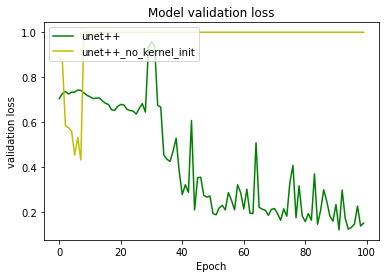

In [54]:
#훈련 과정을 시각화
plt.plot(history3.history['val_loss'], 'g')
plt.plot(history4.history['val_loss'], 'y')
plt.title('Model validation loss')
plt.ylabel('validation loss')
plt.xlabel('Epoch')
plt.legend(['unet++','unet++_no_kernel_init'], loc='upper left')
plt.show()

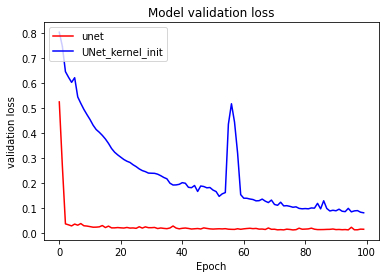

In [63]:
plt.plot(history1.history['val_loss'], 'r')
plt.plot(history2.history['val_loss'], 'b')
plt.title('Model validation loss')
plt.ylabel('validation loss')
plt.xlabel('Epoch')
plt.legend(['unet', 'UNet_kernel_init'], loc='upper left')
plt.show()

모델별 시각화

In [64]:
model_path1 = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'
model_path2 = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_kernel_init.h5'
model_path3 = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_plus_plus.h5'
model_path4 = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_plus_plus2.h5'

model = tf.keras.models.load_model(model_path1)
model2 = tf.keras.models.load_model(model_path2)
model3 = tf.keras.models.load_model(model_path3, custom_objects={'dice_coef_loss': dice_coef_loss})
model4 = tf.keras.models.load_model(model_path4, custom_objects={'dice_coef_loss': dice_coef_loss})

In [85]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction).sum() # intersection
    union = np.logical_or(target, prediction).sum() # Union
    iou_score = float(intersection) / float(union) # iou 스코어
    #print('IoU : %f' % iou_score )
    return iou_score

In [66]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

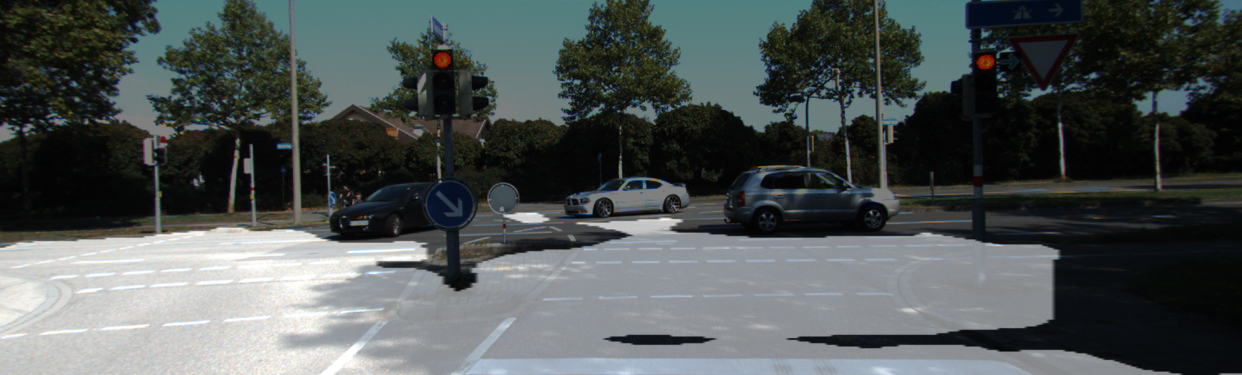

0.7113628482256387

In [67]:
# UNET
i = 10    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

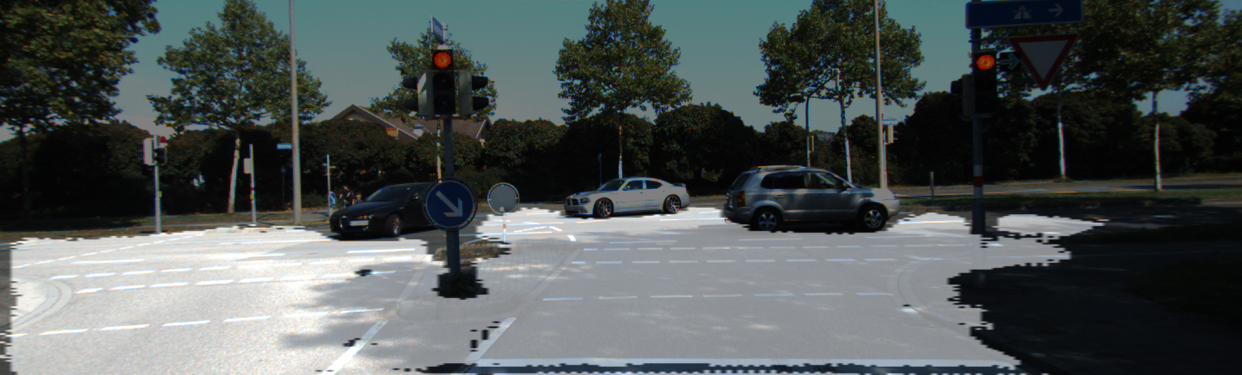

0.7823515210043457

In [68]:
# UNET_KERNEL_INIT, BATCH
i = 10    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model2, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

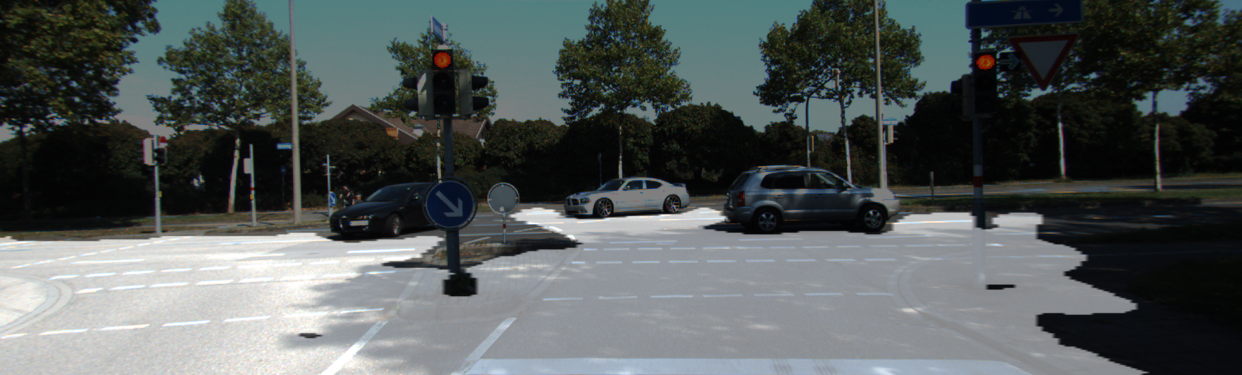

0.7507184312841607

In [69]:
# UNET++
i = 10    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model3, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

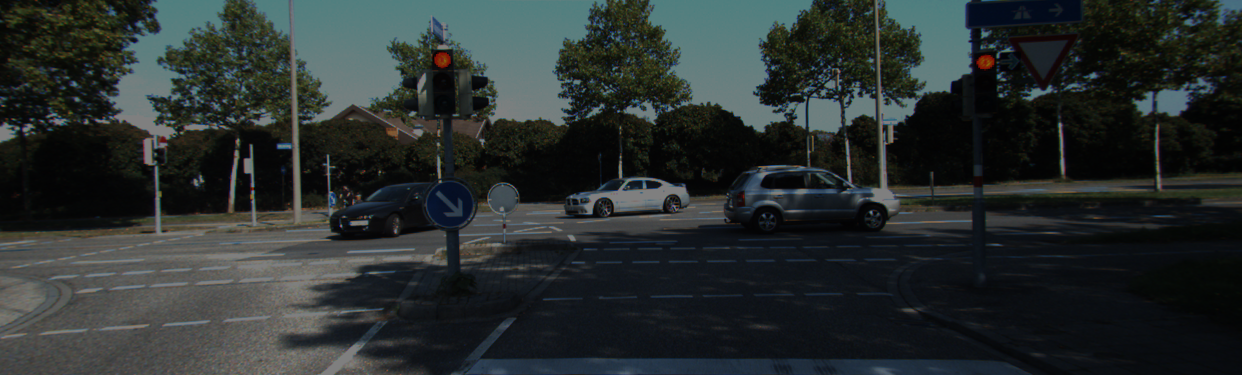

0.0

In [70]:
# UNET++ KERNELINIT, BATCH
i = 10    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model4, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

In [105]:
def get_output_iou(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.4).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [110]:
iou_score_unet=[]
iou_score_unet_kernel_init=[]
iou_score_unet_plus_plus=[]
iou_score_unet_plus_plus_no_kernel_init=[]

for i in range(199) :
    output, prediction, target = get_output_iou(
        model, test_preproc,
        image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
        output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
        label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
        )
    iou_score_unet.append(calculate_iou_score(target, prediction))  

In [111]:
 for i in range(199) :   
    output, prediction, target = get_output_iou(
        model2, test_preproc,
        image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
        output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
        label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
        )
    iou_score_unet_kernel_init.append(calculate_iou_score(target, prediction))

In [112]:
 for i in range(199) :       
    output, prediction, target = get_output_iou(
        model3, test_preproc,
        image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
        output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
        label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
        )
    iou_score_unet_plus_plus.append(calculate_iou_score(target, prediction))

In [113]:
for i in range(199) :   
    output, prediction, target = get_output_iou(
        model4, test_preproc,
        image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
        output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
        label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
        )
    iou_score_unet_plus_plus_no_kernel_init.append(calculate_iou_score(target, prediction))

threshold를 0.5로 했을 때 모델별 iou 값(평균)

In [101]:
#전체 unet1 iou 계산
average = sum(iou_score_unet) / len(iou_score_unet)
print(average)

0.7027544791444758


In [102]:
#전체 unet2 iou 계산
average = sum(iou_score_unet_kernel_init) / len(iou_score_unet_kernel_init)
print(average)

0.7208495451392185


In [103]:
#전체 unet++ iou 계산
average = sum(iou_score_unet_plus_plus) / len(iou_score_unet_plus_plus)
print(average)

0.7020374084223902


In [104]:
#전체 unet++2 iou 계산
average = sum(iou_score_unet_plus_plus_no_kernel_init) / len(iou_score_unet_plus_plus_no_kernel_init)
print(average)

0.0


threshold를 0.4로 했을 때 모델별 iou 값(평균)

In [114]:
#전체 unet1 iou 계산
average = sum(iou_score_unet) / len(iou_score_unet)
print(average)

0.7440367801391831


In [115]:
#전체 unet2 iou 계산
average = sum(iou_score_unet_kernel_init) / len(iou_score_unet_kernel_init)
print(average)

0.7391626085201976


In [116]:
#전체 unet++ iou 계산
average = sum(iou_score_unet_plus_plus) / len(iou_score_unet_plus_plus)
print(average)

0.7040954894285224


In [117]:
#전체 unet++2 iou 계산
average = sum(iou_score_unet_plus_plus_no_kernel_init) / len(iou_score_unet_plus_plus_no_kernel_init)
print(average)

0.0


Unet++ 구조를 만들어보면서 중간부분을 연결하는 과정에서 한두개씩 conv2d 레이러를 잘못 연결해서 어느 에포크순간에 튀는 현상이 발생했었다. 그래서 Unet++를 많이 수정했었다.
unet과 unet++의 로스를 비교했을 때, unet 로스가 10배가량 작게 나왔는데 이건 loss를 다르게 사용해서 그런것 같다. unet은 binary crossentropy를 사용했고, unet++는 dice_coff_loss를 사용했다. 이 차이로 인하여 로스값이 다르게 나오는것 같다.
이미지를 불러와 결과를 살펴보고 iou를 계산해봤는데, 이미지로 봤을 땐 unet++가 segmentation 부분이 좀더 곡선형태로 부드럽게 표현되었다. 사진 한개로 iou를 비교해봤을 땐 unet++가 unet보다 성능이 좋게 나왔다.

수정 후 회고  
일단 unet 모델을 만들 때 수정하기 전에 몇몇 conv2d레이러를 잘못 설정하여 그 부분을 수정했다. 그런데 model4(unet++)가 일정 에포크 이상부터 로스가 0.9999로 수렴하는 문제가 발생하여 이 문제를 해결하지 못했다. 추후에 해결할 예정이다. 그리고 unet 모델을 구성할 때, Conv2DTranspose와 upsampling의 차이, BatchNormalization의 효과, kernel_initializer = 'he_normal' 효과를 알고 싶어 모델을 여러가지 만들어 보려고 했다. 하지만 시간이 없어서 섞어서 만들었다. 현재 테스트 한것 기준으로는 BatchNormalization을 적용한 모델의 validation loss 그래프가 적용하지 않은 모델보다 괜찮게 그려졌다.(하지만 loss 값은 적용하지 않은 모델의 loss가 더 낮게 나왔다.) upsampling과 conv2dtranspose의 차이는 현재 테스트 진행만으로는 확인할 수 없었다. kernel_initializer도 마찬가지이다. 추후에 다양하게 모델을 만들어 보면서 테스트 해볼 것이다.  
unet과 unet++를 비교해봤을 땐 이전 회고에서도 작성했듯이. loss를 다르게 설정하여 loss값이 차이가 나는것 같고, iou는 unet이 더 잘 나왔다. 임의의 사진을 뽑아서 비교해봤을 땐, unet++가 좀 더 곡선의 형태로 도로 class를 표현한것 같다. 위에서 모델을 수정하면서 사진들을 좀 더 보면서 차이점을 확인해 봐야겠다.  
threshold를 변경하면 iou 값도 변경되어 iou값을 평가지표로 삼기전에 threshold 기준을 잡고 평가지표로 삼아야 한다는 것을 알았다. 
추가로 unet++에서 deep supervision에 대해서 알게 되었는데, 아직 적용을 시켜보지 못했다. 이 부분도 좀 더 찾아보고 모델에 적용해볼 예정이다.